In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import norse

# 2. Spiking neurons

Spiking neuron models are given as (typically very simple) systems of ordinary differential
equations. A common example used is the so called current based leaky integrate and fire neuron model (LIF). Its differential equation is given by
\begin{align*}
\dot{v} &= -(v - v_\text{reset}) + I \\
\dot{I} &= -I + I_\text{in}
\end{align*}
together with jump and transition equations, that specify when a jump occurs and
how the state variables change. A prototypical equation is a leaky integrator
with constant current input $I_\text{in}$, with jump condition $v - 1 = 0$ and transition equation $v^+ - v^- = -1$.


In [2]:
from norse.torch.functional import (
    lif_step,
    lift,
    lif_feed_forward_step,
    lif_current_encoder,
    LIFParameters,
)

N = 1  # number of neurons to consider
T = 100  # number of timesteps to integrate

p = LIFParameters()
v = torch.zeros(N)  # initial membrane voltage
input_current = 1.1 * torch.ones(N)

voltages = []

for ts in range(T):
    z, v = lif_current_encoder(input_current, v, p)
    voltages.append(v)

voltages = torch.stack(voltages)

We can now plot the voltages over time:

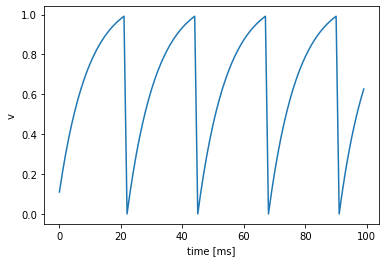

In [3]:
plt.ylabel("v")
plt.xlabel("time [ms]")
plt.plot(voltages)

# 3. MNIST Task

A common toy dataset to test machine learning approaches on is the MNIST handwritten digit recognition dataset. The goal is to distinguish handwritten digits 0..9 based on a 28x28 grayscale picture. Run the cell below to download the training and test data for MNIST.

In [4]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)

## 3.1 Encoding Input Data

One of the distinguishing features of spiking neural networks is that they
operate on temporal data encoded as spikes. Common datasets in machine learning
of course don't use such an encoding and therefore make a encoding step necessary. Here we choose to treat the grayscale value of an MNIST image
as a constant current to produce input spikes to the rest of the network.
Another option would be to interpret the grayscale value as a spike probabilty
at each timestep.


### Constant Current Encoder

In [5]:
from norse.torch import ConstantCurrentLIFEncoder

We can easily visualise the effect of this choice of encoding on a sample image in the training data set

0


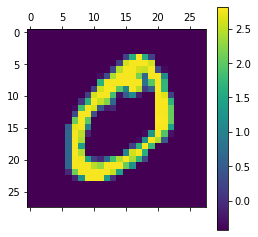

In [6]:
img, label = train_data[1]

plt.matshow(img[0])
plt.colorbar()
print(label)

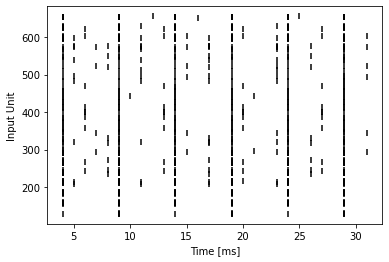

In [7]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

### Poisson Encoding

As can be seen from the spike raster plot, this kind of encoding does not produce spike patterns which are necessarily biologically realistic. We could rectify this situation by employing cells with varying threshholds and a finer integration time step. Alternatively we can encode the grayscale input images into poisson spike trains




In [8]:
from norse.torch import PoissonEncoder

This produces a more biological plausible input pattern, as can be seen below:

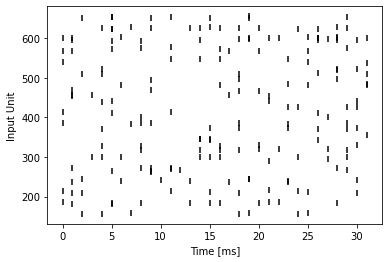

In [9]:
T = 32
example_encoder = PoissonEncoder(T, f_max=20)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

### Spike Latency Encoding

Yet another example is a spike latency encoder. In this case each input neuron spikes only once, the first time the input crosses the threshhold.

In [10]:
from norse.torch import SpikeLatencyLIFEncoder

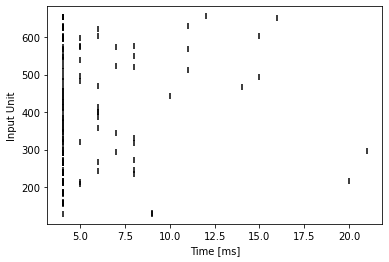

In [11]:
T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

## 3.2  Defining a Network

Once the data is encoded into spikes, a spiking neural network can be constructed in the same way as a one would construct a recurrent neural network.
Here we define a spiking neural network with one recurrently connected layer
with `hidden_features` LIF neurons and a readout layer with `output_features` and leaky-integrators. As you can see, we can freely combine spiking neural network primitives with ordinary `torch.nn.Module` layers.

In [12]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

We can visualize the output produced by the recurrent spiking neural network on the example input.

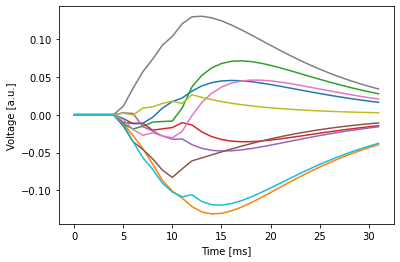

In [13]:
example_snn = SNN(28 * 28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

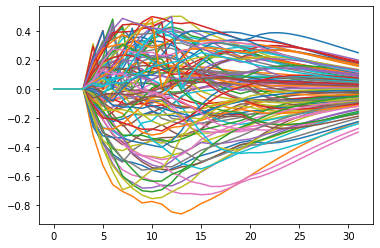

In [14]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

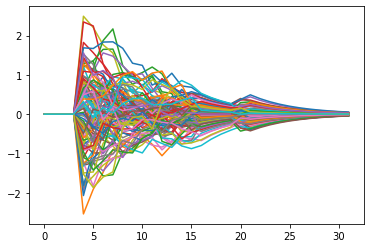

In [15]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

# 3.3 Decoding the Output

The output of the network we have defined are $10$ membrane voltage traces. What remains to do is to interpret those as a probabilty distribution. One way of doing so is to determine the maximum along the time dimension and to then compute the softmax of these values. There are other options of course, for example to consider
the average membrane voltage in a given time window or use a LIF neuron output layer and consider the time to first spike.

In [16]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

An alternative way of decoding would be to consider only the membrane trace at the last measured time step.

In [17]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

## 3.4 Training the Network

The final model is then simply the sequential composition of these three steps: Encoding, a spiking neural network and decoding.

In [18]:
class Model(torch.nn.Module):
    def __init__(self, snn, decoder):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

We can then instantiate the model with the recurrent ```SNN``` network defined above.

In [19]:
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

What remains to do is to setup training and test code. This code is completely independent of the fact that we are training a spiking neural network and in fact has been largely copied from the pytorch tutorials.

In [20]:
from tqdm.notebook import tqdm, trange

EPOCHS = 5  # Increase this number for better performance


def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    )

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        x = encoder(data)
        output = model(x)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

Just like the training function, the test function is standard boilerplate, common with any other supervised learning task.

In [21]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    )
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            x = encoder(data)
            output = model(x)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [22]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

final accuracy: 95.34


We can visualize the output of the trained network on an example input

In [30]:
encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    )
device = DEVICE
adversarial_samples = []
for (data, target) in tqdm(test_loader, leave=False):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    x = encoder(data)
    x.requires_grad = True
    output = model(x)
    loss = torch.nn.functional.nll_loss(output, target)
    loss.backward()
    ## I am saving adversarial sample for first object of the whole batch just for illustration
    sample = [np.array(data[0][0]), np.array(data[0][0]+x.grad.mean(dim=0)[0][0])]
    adversarial_samples.append(sample)

  0%|          | 0/40 [00:00<?, ?it/s]

# Adversarial samples

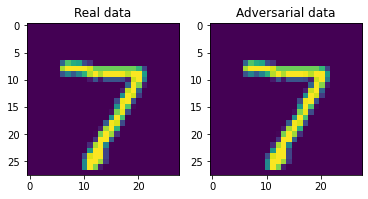

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(adversarial_samples[0][0])
ax2.imshow(adversarial_samples[0][1])
ax1.set_title('Real data');
ax2.set_title('Adversarial data');

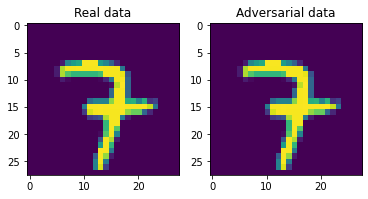

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(adversarial_samples[7][0])
ax2.imshow(adversarial_samples[7][1])
ax1.set_title('Real data');
ax2.set_title('Adversarial data');

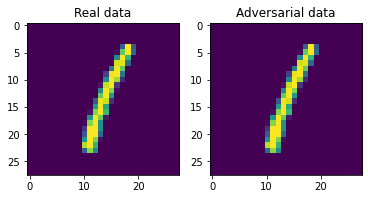

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(adversarial_samples[11][0])
ax2.imshow(adversarial_samples[11][1])
ax1.set_title('Real data');
ax2.set_title('Adversarial data');

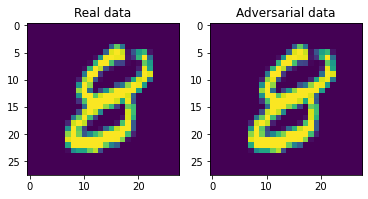

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(adversarial_samples[18][0])
ax2.imshow(adversarial_samples[18][1])
ax1.set_title('Real data');
ax2.set_title('Adversarial data');

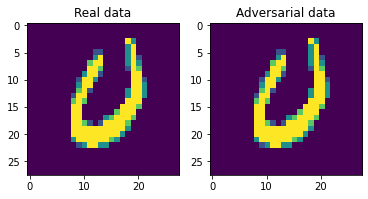

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(adversarial_samples[25][0])
ax2.imshow(adversarial_samples[25][1])
ax1.set_title('Real data');
ax2.set_title('Adversarial data');